In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

from src import inception_v3_imagenet
from src import imagenet_labels
from src import utils
from src.diff_renderer import make_render_op
from src.utils import angles_to_matrix

In [2]:
width, height = 1000, 1000
mesh = utils.load_obj('resources/dog.obj')
original_texture = mesh.texture_image.copy()
render_op = make_render_op(mesh, width, height)

In [3]:
trans = [0, 0, 2.6]
rotation = [0.4, np.pi+.7, 2.9]
fscale = 0.4
bgcolor = [0.9, 0.9, 0.9]
texture_image = mesh.texture_image

In [4]:
view_matrix = np.vstack((np.hstack((angles_to_matrix(rotation) , np.reshape(trans, (3, 1)) )) , np.array([0, 0, 0, 1])))
view_matrix

array([[ 0.74262977,  0.02322123,  0.66929949,  0.        ],
       [-0.18298798, -0.95433222,  0.23614703,  0.        ],
       [ 0.64421769, -0.29784358, -0.70446631,  2.6       ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [5]:
pixel_center_offset = 0.5
near = 0.1
far = 100.

fmat = [float(width) / float(fscale), float(width) / float(fscale)]
f = 0.5 * (fmat[0] + fmat[1])

center = [width/2.,height/2.]

right  =  (width-(center[0]+pixel_center_offset)) * (near/f)
left   =           -(center[0]+pixel_center_offset)  * (near/f)
top    = -(height-(center[1]+pixel_center_offset)) * (near/f)
bottom =            (center[1]+pixel_center_offset)  * (near/f)


A = (right + left) / (right - left)
B = (top + bottom) / (top - bottom)
C = (far + near) / (far - near)
D = (2 * far * near) / (far - near)

camera_matrix = np.array([
    [2 * near / (right - left), 0, A, 0],
    [0, 2 * near / (top - bottom), B, 0],
    [0, 0, C, D],
    [0, 0, -1, 0]
])

In [6]:
proj_matrix = camera_matrix.dot(view_matrix)

In [7]:
homo_v = np.hstack((mesh.v, np.ones((mesh.v.shape[0], 1) )))
homo_v

array([[ 0.04729923, -0.02962504, -0.28196972,  1.        ],
       [ 0.03527478,  0.01396127, -0.29956182,  1.        ],
       [ 0.06153678,  0.01350783, -0.29312388,  1.        ],
       ..., 
       [ 0.04403177,  0.2615302 ,  0.38719011,  1.        ],
       [ 0.03651725,  0.24862289,  0.39145738,  1.        ],
       [ 0.03867221,  0.26496691,  0.38782987,  1.        ]])

In [8]:
abnormal = proj_matrix.dot(homo_v.reshape((-1, 4, 1)))[:, :, 0]
XY = (abnormal[:,:] / abnormal[3,:]).T
XY

array([[ 0.27282516, -0.0817528 , -1.07254638,  1.        ],
       [ 0.3084223 , -0.15895063, -1.07275418,  1.        ],
       [ 0.2651957 , -0.16326456, -1.07244255,  1.        ],
       ..., 
       [-0.65298731, -0.36386272, -1.08989744,  1.        ],
       [-0.64748836, -0.33217757, -1.09005218,  1.        ],
       [-0.64676643, -0.36937906, -1.09008799,  1.        ]])

(1, -1)

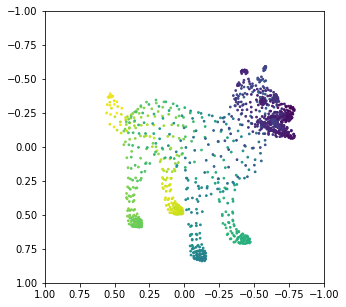

In [9]:

# plt.set_autoscale_on(False)
plt.figure(figsize=(5,5))
plt.scatter(XY[:,0], XY[:, 1], c = XY[:, 2], s=3)
# plt.axes().set_aspect('equal', 'datalim')

plt.xlim([1, -1])
plt.ylim([1, -1])



In [10]:
mesh.f.shape

(2652, 3)

In [11]:
Z = XY[:,2]

face_depth = np.mean(np.take(Z, mesh.f.flatten()).reshape((-1, 3)), axis=1)

In [12]:
face_depth

array([-1.07258104, -1.07237991, -1.07285156, ..., -1.09000121,
       -1.09020616, -1.09011096])

In [13]:
XY[0,:]

array([ 0.27282516, -0.0817528 , -1.07254638,  1.        ])

In [14]:
T = np.take(XY[:,0:2], mesh.f[0], axis=0)
T

array([[ 0.27282516, -0.0817528 ],
       [ 0.3084223 , -0.15895063],
       [ 0.2651957 , -0.16326456]])

In [15]:
np.take(XY[:,0:2], mesh.f, axis=0).shape

(2652, 3, 2)

In [16]:
np.mean(T[:,1])

-0.13465599682771923

In [17]:
px = 0.28214771774793101
py = -0.13465599682771923

# T = np.array([[ 0.27282516, -0.0817528 ],
#        [ 0.3084223 , -0.15895063],
#        [ 0.2651957 , -0.16326456]])
T = np.array([[ 0.27282516, -0.0817528 ],
[ 0.2651957 , -0.16326456],
[ 0.3084223 , -0.15895063]])

s = (T[0,1] * T[2,0] - T[0,0] * T[2,1] + (T[2,1] - T[0,1]) * px + (T[0,0] - T[2,0]) * py)
t = (T[0,0] * T[1,1] - T[0,1] * T[1,0] + (T[0,1] - T[1,1]) * px + (T[1,0] - T[0,0]) * py)

# this can be a precomputed quantity eh?
A = (-T[1,1] * T[2,0] + T[0,1] * (-T[1,0] + T[2,0]) + T[0,0] * (T[1,1] - T[2,1]) + T[1,0] * T[2,1])

s > 0 and t > 0 and (s + t) < A

True

In [18]:
T = np.take(XY[:,0:2], mesh.f, axis=0)

T[:,0,1]

array([-0.0817528 , -0.07638054, -0.13980366, ..., -0.36937906,
       -0.34340723, -0.34340723])

In [19]:
px = 0.28214771774793101
py = -0.13465599682771923

T = np.take(XY[:,0:2], mesh.f, axis=0)

s = T[:,0,1] * T[:,2,0] - T[:,0,0] * T[:,2,1] + (T[:,2,1] - T[:,0,1]) * px + (T[:,0,0] - T[:,2,0]) * py
t = T[:,0,0] * T[:,1,1] - T[:,0,1] * T[:,1,0] + (T[:,0,1] - T[:,1,1]) * px + (T[:,1,0] - T[:,0,0]) * py

# this can be a precomputed quantity eh?
A = (-T[:,1,1] * T[:,2,0] + T[:,0,1] * (-T[:,1,0] + T[:,2,0]) + T[:,0,0] * (T[:,1,1] - T[:,2,1]) + T[:,1,0] * T[:,2,1])

# s > 0 and t > 0 and (s + t) < A

np.where(np.logical_and(np.logical_and(s > 0, t > 0), s + t < A))

(array([940]),)

In [20]:
px = 0.28214771774793101
py = -0.13465599682771923

T = np.take(XY[:,0:2], mesh.f, axis=0)

s = (T[:,2,1] - T[:,0,1]) * px + (T[:,0,0] - T[:,2,0]) * py
t = (T[:,0,1] - T[:,1,1]) * px + (T[:,1,0] - T[:,0,0]) * py

# this can be a precomputed quantity eh?
A = -T[:,1,1] * T[:,2,0] + T[:,0,1] * (-T[:,1,0] + T[:,2,0]) + T[:,0,0] * (T[:,1,1] - T[:,2,1]) + T[:,1,0] * T[:,2,1] -(T[:,0,1] * T[:,2,0] - T[:,0,0] * T[:,2,1]) -(T[:,0,0] * T[:,1,1] - T[:,0,1] * T[:,1,0])

# s > 0 and t > 0 and (s + t) < A

np.where(np.logical_and(np.logical_and(s > -(T[:,0,1] * T[:,2,0] - T[:,0,0] * T[:,2,1]), t > -(T[:,0,0] * T[:,1,1] - T[:,0,1] * T[:,1,0])), s + t < A))

(array([940]),)

In [21]:
# x, y -> all(A,B,C > 0) if on pixel

[px, py]

[0.282147717747931, -0.13465599682771923]

In [22]:
T[:,2,1] - T[:,0,1]
T[:,0,0] - T[:,2,0]

T[:,0,1] * T[:,2,0] - T[:,0,0] * T[:,2,1]
T[:,0,0] * T[:,1,1] - T[:,0,1] * T[:,1,0]

array([-0.01815134,  0.00078392, -0.0123737 , ..., -0.0094715 ,
       -0.00098263, -0.00308003])

In [23]:
# np.linspace(-1., 1., 100)



np.expand_dims(T[:,2,1] - T[:,0,1], 1).dot(np.expand_dims(np.linspace(-1., 1., 1000), 0))

array([[ 0.08151176,  0.08134857,  0.08118539, ..., -0.08118539,
        -0.08134857, -0.08151176],
       [ 0.08688402,  0.08671007,  0.08653613, ..., -0.08653613,
        -0.08671007, -0.08688402],
       [-0.05805086, -0.05793464, -0.05781843, ...,  0.05781843,
         0.05793464,  0.05805086],
       ..., 
       [-0.00551635, -0.0055053 , -0.00549426, ...,  0.00549426,
         0.0055053 ,  0.00551635],
       [-0.01081794, -0.01079628, -0.01077463, ...,  0.01077463,
         0.01079628,  0.01081794],
       [-0.00537447, -0.00536371, -0.00535295, ...,  0.00535295,
         0.00536371,  0.00537447]])

In [24]:
len(mesh.f)

2652

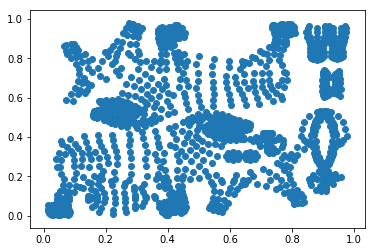

In [25]:
plt.scatter(mesh.vt[:,0], mesh.vt[:,1])

In [26]:
import matplotlib.cm as cm

In [ ]:
blank_canvas = 1000x1000
for i in triangles:
    blank_canvas = blank_canvas + add_triangle

In [ ]:
blank_canvas = 1000x1000
canvas = map(blank_canvas, max(z for each triangle intersecting x,y))

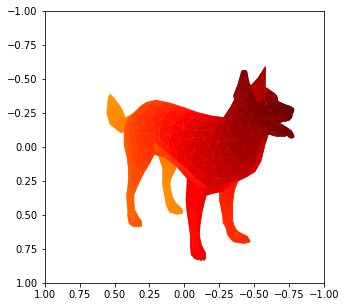

In [27]:
plt.figure(figsize=(5,5))

for i in range(len(mesh.f)):
    tri = np.take(XY[:,0:2], mesh.f[i], axis=0)
    circle = plt.Polygon(tri, fc=cm.hot( (1.1 + face_depth[i]) * 20))
    plt.gca().add_patch(circle)

plt.xlim([1, -1])
plt.ylim([1, -1])

plt.show()

In [28]:
np.array(np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000)))

array([[[ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        ..., 
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
        [ 0.001001,  0.001001,  0.001001, ...,  0.001001,  0.001001,
          0.001001],
        [ 0.002002,  0.002002,  0.002002, ...,  0.002002,  0.002002,
          0.002002],
        ..., 
        [ 0.997998,  0.997998,  0.997998, ...,  0.997998,  0.997998,
          0.997998],
        [ 0.998999,  0.998999,  0.998999, ...,  0.998999,  0.998999,
          0.998999],
        [ 1.      ,  1.      ,  1.      , .